## Prophet Model for Ride Wait Time Forecasting

This notebook applies the Prophet forecasting model to theme park ride wait time data.
We'll predict wait times for the "Silver Star" roller coaster using weather data, holidays, and other features.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import prophet
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Define consistent colors for plots
TRAIN_COLOR = 'steelblue'
TRAIN_FILL_COLOR = 'steelblue'
TRAIN_FILL_ALPHA = 0.3
VAL_COLOR = 'coral'
VAL_FILL_COLOR = 'coral'
VAL_FILL_ALPHA = 0.3

## Data Loading and Initial Preprocessing

First, we load the parquet file containing wait time data and select a specific ride.
Then we perform basic preprocessing like resampling and filtering by season.

In [3]:
def load_ride_data(file_path, ride_name):
    """Load data for a specific ride and perform initial preprocessing."""
    full_data = pd.read_parquet(file_path)
    
    # Filter for the specified ride
    ride_data = full_data.loc[full_data["ride_name"] == ride_name].reset_index(drop=True)
    ride_data.loc[:, "closed"] = ride_data["closed"].astype(bool).astype(int)
    
    # Resample to 30-minute intervals
    ride_data = ride_data.set_index("timestamp").resample("30min").ffill().reset_index()
    
    # Remove off-season data (January-March)
    ride_data = ride_data.loc[ride_data["timestamp"].dt.month > 3].reset_index(drop=True)
    
    return ride_data

In [4]:
# Load data
input_file = "../data/processed/ep/merged_with_holidays.parquet"
ride_name = "silver star"

# Process ride data
ride_df = load_ride_data(input_file, ride_name)
ride_df

/tmp/ipykernel_14483/955052940.py:7: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[0 0 0 ... 1 1 1]' has dtype incompatible with bool, please explicitly cast to a compatible dtype first.
  ride_data.loc[:, "closed"] = ride_data["closed"].astype(bool).astype(int)


,timestamp,ride_name,wait_time,closed,temperature,rain,wind,is_german_holiday,is_swiss_holiday,is_french_holiday
0,2017-05-23 09:00:00,silver star,0.0,0,18.7,0.0,1.1,False,False,False
1,2017-05-23 09:30:00,silver star,10.0,0,18.7,0.0,1.1,False,False,False
2,2017-05-23 10:00:00,silver star,10.0,0,21.5,0.0,0.7,False,False,False
3,2017-05-23 10:30:00,silver star,25.0,0,21.5,0.0,0.7,False,False,False
4,2017-05-23 11:00:00,silver star,15.0,0,23.8,0.0,1.8,False,False,False
...,...,...,...,...,...,...,...,...,...,...
103076,2024-12-31 19:00:00,silver star,0.0,1,NaN,NaN,NaN,False,False,False
103077,2024-12-31 19:30:00,silver star,0.0,1,NaN,NaN,NaN,False,False,False
103078,2024-12-31 20:00:00,silver star,0.0,1,NaN,NaN,NaN,False,False,False
103079,2024-12-31 20:30:00,silver star,0.0,1,NaN,NaN,NaN,False,False,False


## Filtering Out Problematic Days

We remove days when the ride was fully closed or had no recorded wait times.
This helps ensure our model learns from valid operational patterns.

In [5]:
def remove_closed_and_zero_wait_days(ride_data):
    """Remove days when the ride was fully closed or had no recorded wait times."""
    # Identify and remove fully closed days
    daily_closure_status = ride_data.groupby(ride_data["timestamp"].dt.date)["closed"].mean()
    fully_closed_days = daily_closure_status[daily_closure_status == 1].index
    
    print(f"Number of fully closed days: {len(fully_closed_days)}")
    print("Sample of fully closed days:", fully_closed_days[:10])
    
    ride_data = ride_data[~ride_data["timestamp"].dt.date.isin(fully_closed_days)]
    
    # Identify and remove days with zero wait times
    daily_wait_times = ride_data.groupby(ride_data["timestamp"].dt.date)["wait_time"].mean()
    zero_wait_days = daily_wait_times[daily_wait_times < 1].index
    
    print(f"Number of days with zero wait times: {len(zero_wait_days)}")
    print("Sample of zero wait time days:", zero_wait_days[:10])
    
    ride_data = ride_data[~ride_data["timestamp"].dt.date.isin(zero_wait_days)]
    
    return ride_data

In [6]:
# Remove closed days and days with zero wait times
ride_df = remove_closed_and_zero_wait_days(ride_df)
ride_df

Number of fully closed days: 283
Sample of fully closed days: Index([2017-09-10, 2017-10-14, 2017-11-06, 2017-11-07, 2017-11-08, 2017-11-09,
       2017-11-10, 2017-11-11, 2017-11-12, 2017-11-13],
      dtype='object', name='timestamp')
Number of days with zero wait times: 82
Sample of zero wait time days: Index([2017-11-25, 2017-11-26, 2017-11-27, 2017-11-28, 2017-11-29, 2017-11-30,
       2017-12-01, 2017-12-02, 2017-12-03, 2017-12-04],
      dtype='object', name='timestamp')


,timestamp,ride_name,wait_time,closed,temperature,rain,wind,is_german_holiday,is_swiss_holiday,is_french_holiday
0,2017-05-23 09:00:00,silver star,0.0,0,18.7,0.0,1.1,False,False,False
1,2017-05-23 09:30:00,silver star,10.0,0,18.7,0.0,1.1,False,False,False
2,2017-05-23 10:00:00,silver star,10.0,0,21.5,0.0,0.7,False,False,False
3,2017-05-23 10:30:00,silver star,25.0,0,21.5,0.0,0.7,False,False,False
4,2017-05-23 11:00:00,silver star,15.0,0,23.8,0.0,1.8,False,False,False
...,...,...,...,...,...,...,...,...,...,...
103076,2024-12-31 19:00:00,silver star,0.0,1,NaN,NaN,NaN,False,False,False
103077,2024-12-31 19:30:00,silver star,0.0,1,NaN,NaN,NaN,False,False,False
103078,2024-12-31 20:00:00,silver star,0.0,1,NaN,NaN,NaN,False,False,False
103079,2024-12-31 20:30:00,silver star,0.0,1,NaN,NaN,NaN,False,False,False


## Operating Hours Detection

Theme parks have varying operating hours. Here we infer the operating hours
from the data and filter to only include times when the ride was operational.

In [7]:
def filter_to_operating_hours(ride_data):
    """Keep only data during ride operating hours."""
    # Determine operating hours from data where wait times > 0
    operating_hours = ride_data[ride_data["wait_time"] > 0].groupby(
        ride_data["timestamp"].dt.date
    )["timestamp"].agg(['min', 'max']).reset_index()
    
    # Extract opening and closing hours
    operating_hours['opening_hour'] = pd.to_datetime(operating_hours['min']).dt.hour
    operating_hours['closing_hour'] = pd.to_datetime(operating_hours['max']).dt.hour
    
    # Set reasonable boundaries for operating hours
    operating_hours['opening_hour'] = operating_hours['opening_hour'].clip(lower=9, upper=11)
    operating_hours['closing_hour'] = operating_hours['closing_hour'].clip(lower=17, upper=21)
    
    # Create date-to-hours mapping
    date_to_hours = {}
    for _, row in operating_hours.iterrows():
        date_to_hours[row['timestamp']] = (row['opening_hour'], row['closing_hour'])
    
    # Filter data to operating hours only
    def is_operating_hour(timestamp):
        date = timestamp.date()
        assert date in date_to_hours, f"Date {date} not found in operating hours mapping."
        
        open_hour, close_hour = date_to_hours[date]
        hour = timestamp.hour
        return 1 if open_hour <= hour < close_hour else 0
    
    ride_data['operating_hour'] = ride_data['timestamp'].apply(is_operating_hour)
    ride_data = ride_data[ride_data['operating_hour'] == 1]
    ride_data = ride_data.drop(columns=["operating_hour"])
    
    return ride_data

In [8]:
# Filter to operating hours only
ride_df = filter_to_operating_hours(ride_df)
ride_df

,timestamp,ride_name,wait_time,closed,temperature,rain,wind,is_german_holiday,is_swiss_holiday,is_french_holiday
0,2017-05-23 09:00:00,silver star,0.0,0,18.7,0.0,1.1,False,False,False
1,2017-05-23 09:30:00,silver star,10.0,0,18.7,0.0,1.1,False,False,False
2,2017-05-23 10:00:00,silver star,10.0,0,21.5,0.0,0.7,False,False,False
3,2017-05-23 10:30:00,silver star,25.0,0,21.5,0.0,0.7,False,False,False
4,2017-05-23 11:00:00,silver star,15.0,0,23.8,0.0,1.8,False,False,False
...,...,...,...,...,...,...,...,...,...,...
103069,2024-12-31 15:30:00,silver star,NaN,0,0.8,0.0,1.3,False,False,False
103070,2024-12-31 16:00:00,silver star,10.0,0,0.7,0.0,0.8,False,False,False
103071,2024-12-31 16:30:00,silver star,35.0,0,0.7,0.0,0.8,False,False,False
103072,2024-12-31 17:00:00,silver star,35.0,0,-0.2,0.0,1.6,False,False,False


## Feature Engineering for Prophet

We prepare the data for Prophet by renaming columns and creating additional features.
This includes weather transformations and interaction terms to capture complex relationships.

In [9]:
def prepare_data_for_prophet(ride_data):
    """Transform data into format required by Prophet with feature engineering."""
    # Select relevant columns and rename for Prophet
    prophet_data = ride_data[["timestamp", "wait_time", "closed", "temperature", "rain"]]
    prophet_data = prophet_data.rename(columns={"timestamp": "ds", "wait_time": "y"})
    
    # Set weather to 0 when ride is closed
    prophet_data.loc[prophet_data["closed"] == 1, "temperature"] = 0
    prophet_data.loc[prophet_data["closed"] == 1, "rain"] = 0
    
    # Fill missing values
    prophet_data["temperature"] = prophet_data["temperature"].ffill()
    prophet_data["rain"] = prophet_data["rain"].ffill()
    
    # Add transformed variables and interaction terms
    prophet_data['temp_squared'] = prophet_data['temperature'] ** 2
    prophet_data['high_temp'] = (prophet_data['temperature'] > 25).astype(int)
    prophet_data['any_rain'] = (prophet_data['rain'] > 0).astype(int)
    prophet_data['is_weekend'] = prophet_data['ds'].dt.dayofweek.isin([5, 6]).astype(int)
    prophet_data['temp_weekend'] = prophet_data['temperature'] * prophet_data['is_weekend']
    prophet_data['rain_weekend'] = prophet_data['rain'] * prophet_data['is_weekend']
    
    return prophet_data

In [10]:
# Create Prophet-ready dataframe with feature engineering
prophet_df = prepare_data_for_prophet(ride_df)
prophet_df

,ds,y,closed,temperature,rain,temp_squared,high_temp,any_rain,is_weekend,temp_weekend,rain_weekend
0,2017-05-23 09:00:00,0.0,0,18.7,0.0,349.69,0,0,0,0.0,0.0
1,2017-05-23 09:30:00,10.0,0,18.7,0.0,349.69,0,0,0,0.0,0.0
2,2017-05-23 10:00:00,10.0,0,21.5,0.0,462.25,0,0,0,0.0,0.0
3,2017-05-23 10:30:00,25.0,0,21.5,0.0,462.25,0,0,0,0.0,0.0
4,2017-05-23 11:00:00,15.0,0,23.8,0.0,566.44,0,0,0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...
103069,2024-12-31 15:30:00,NaN,0,0.8,0.0,0.64,0,0,0,0.0,0.0
103070,2024-12-31 16:00:00,10.0,0,0.7,0.0,0.49,0,0,0,0.0,0.0
103071,2024-12-31 16:30:00,35.0,0,0.7,0.0,0.49,0,0,0,0.0,0.0
103072,2024-12-31 17:00:00,35.0,0,-0.2,0.0,0.04,0,0,0,-0.0,0.0


## Data Visualization

Let's visualize the key features to understand patterns and relationships.

In [11]:
def plot_features(df, features):
    """Plot multiple features over time in a 2-column grid layout."""
    n_features = len(features)
    n_rows = (n_features + 1) // 2  # Ceiling division for number of rows
    
    fig, axes = plt.subplots(n_rows, 2, figsize=(16, 4 * n_rows))
    if n_rows == 1 and n_features == 1:
        axes = np.array([axes])  # Make sure axes is always a 2D array
    elif n_rows == 1:
        axes = axes.reshape(1, 2)
    
    for i, feature in enumerate(features):
        row, col = i // 2, i % 2
        ax = axes[row, col]
        
        ax.plot(df["ds"], df[feature], label=feature)
        ax.set_title(f"{feature} over Time")
        ax.set_xlabel("Date")
        ax.set_ylabel(feature)
        ax.legend()
        ax.grid(True, linestyle=':')
    
    # Hide unused subplots
    for i in range(n_features, n_rows * 2):
        row, col = i // 2, i % 2
        if row < axes.shape[0] and col < axes.shape[1]:  # Check if this subplot exists
            fig.delaxes(axes[row, col])
    
    plt.tight_layout()
    plt.show()

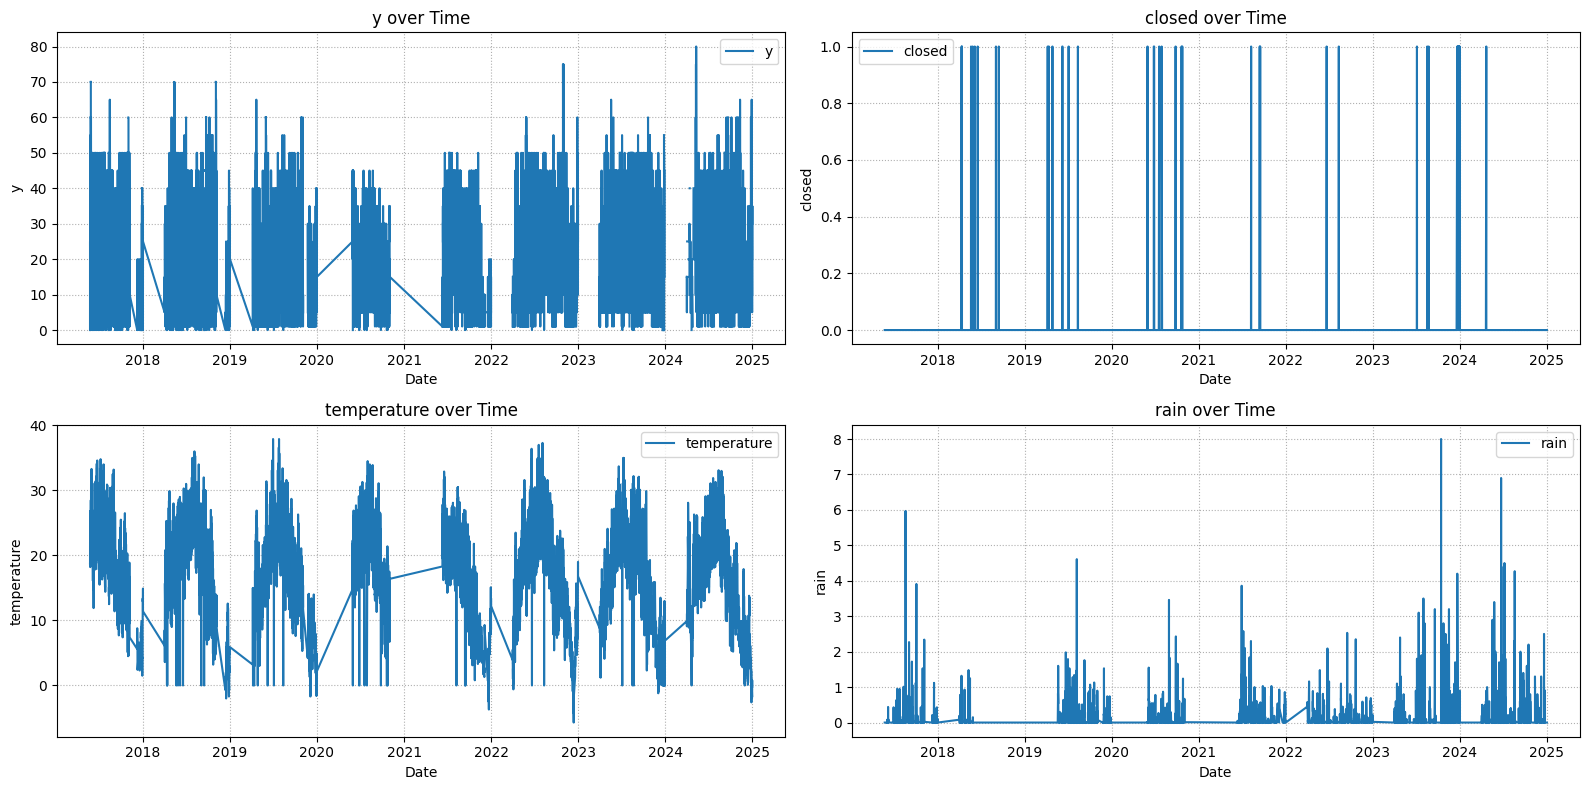

In [12]:
# Visualize key features
plot_features(prophet_df, ["y", "closed", "temperature", "rain"])

## Holiday Effects

Theme parks are heavily influenced by holidays as they can significantly increase visitor numbers.
We create holiday dataframes for different countries and special periods like COVID.

In [13]:
def create_holiday_dataframes(ride_data):
    """Create holiday dataframes for Prophet model."""
    holiday_dfs = []
    
    # Process country holidays
    for country in ['swiss', 'german', 'french']:
        holiday_col = f"is_{country}_holiday"
        if holiday_col in ride_data.columns:
            country_holidays = ride_data.loc[ride_data[holiday_col] == 1, ["timestamp"]]
            if len(country_holidays) > 0:
                country_holidays["ds"] = pd.to_datetime(country_holidays["timestamp"]).dt.date
                country_holidays = country_holidays.drop_duplicates(subset=["ds"])
                country_holidays = country_holidays.drop(columns=["timestamp"])
                country_holidays["holiday"] = f"{country}_holiday"
                country_holidays["lower_window"] = 0
                country_holidays["upper_window"] = 0
                holiday_dfs.append(country_holidays.reset_index(drop=True))
    
    # Add COVID periods
    covid_era = pd.DataFrame({
        'holiday': 'covid_era',
        'ds': pd.date_range(start='2020-04-15', end='2020-05-20'),
        'lower_window': 0,
        'upper_window': 0
    })
    
    covid_recovery = pd.DataFrame({
        'holiday': 'covid_recovery',
        'ds': pd.date_range(start='2021-05-21', end='2021-07-31'),
        'lower_window': 0,
        'upper_window': 0
    })
    
    holiday_dfs.extend([covid_era, covid_recovery])
    
    # Combine all holidays
    all_holidays = pd.concat(holiday_dfs)
    all_holidays["ds"] = pd.to_datetime(all_holidays["ds"])
    
    return all_holidays.sort_values(by=["ds"]).reset_index(drop=True)

In [14]:
# Create holiday dataframes
holidays_df = create_holiday_dataframes(ride_df)
holidays_df.head()

,ds,holiday,lower_window,upper_window
0,2017-05-25,swiss_holiday,0,0
1,2017-05-25,french_holiday,0,0
2,2017-05-25,german_holiday,0,0
3,2017-05-27,french_holiday,0,0
4,2017-06-05,german_holiday,0,0


## Train-Test Split

We split our data into training (pre-2023) and validation (2023) sets to evaluate our model.

In [15]:
# Sort data chronologically
prophet_df = prophet_df.sort_values(by="ds")

# Split into training and validation sets
train_df = prophet_df.loc[(prophet_df["ds"] < "2023-01-01")].reset_index(drop=True)
val_df = prophet_df.loc[(prophet_df["ds"] >= "2023-01-01") & 
                        (prophet_df["ds"] < "2024-01-01")].reset_index(drop=True)

print(f"Training data: {train_df.shape[0]} rows from {train_df['ds'].min()} to {train_df['ds'].max()}")
print(f"Validation data: {val_df.shape[0]} rows from {val_df['ds'].min()} to {val_df['ds'].max()}")

Training data: 22104 rows from 2017-05-23 09:00:00 to 2022-12-31 17:30:00
Validation data: 4184 rows from 2023-04-01 09:00:00 to 2023-12-31 16:30:00


## Model Configuration and Training

We configure the Prophet model with parameters optimized for theme park wait time prediction.
The model accounts for seasonality, holidays, and weather effects.

In [16]:
# Create Prophet model with appropriate parameters
model = prophet.Prophet(
    # Core parameters
    seasonality_mode='multiplicative',  # Better for tourism/attraction data
    changepoint_prior_scale=0.05,       # Flexibility in trend changes
    changepoint_range=0.95,             # Allow changepoints closer to the end of the training data

    # Handling closures
    seasonality_prior_scale=12,         # Stronger seasonality influence
    yearly_seasonality=True,            # Capture yearly patterns
    weekly_seasonality=True,            # Capture weekly patterns
    daily_seasonality=True,             # We'll add custom daily seasonality for operating hours

    # Specific to park operation
    holidays_prior_scale=15,            # Strong holiday effects for parks
    holidays=holidays_df,               # Include holidays and covid lockdowns
)

# Add weather and interaction regressors
model.add_regressor('temperature', mode='multiplicative', standardize=True)
model.add_regressor('rain', mode='multiplicative', standardize=True)
model.add_regressor('temp_squared', mode='additive', standardize=True)
model.add_regressor('high_temp', mode='multiplicative', standardize=False)
model.add_regressor('any_rain', mode='multiplicative', standardize=False)
model.add_regressor('temp_weekend', mode='additive', standardize=True)
model.add_regressor('rain_weekend', mode='multiplicative', standardize=True)

# Fit model on training data
model.fit(train_df)

17:59:50 - cmdstanpy - INFO - Chain [1] start processing
18:00:17 - cmdstanpy - INFO - Chain [1] done processing


## Generating Forecasts

We generate forecasts for both training and validation periods and visualize model components.

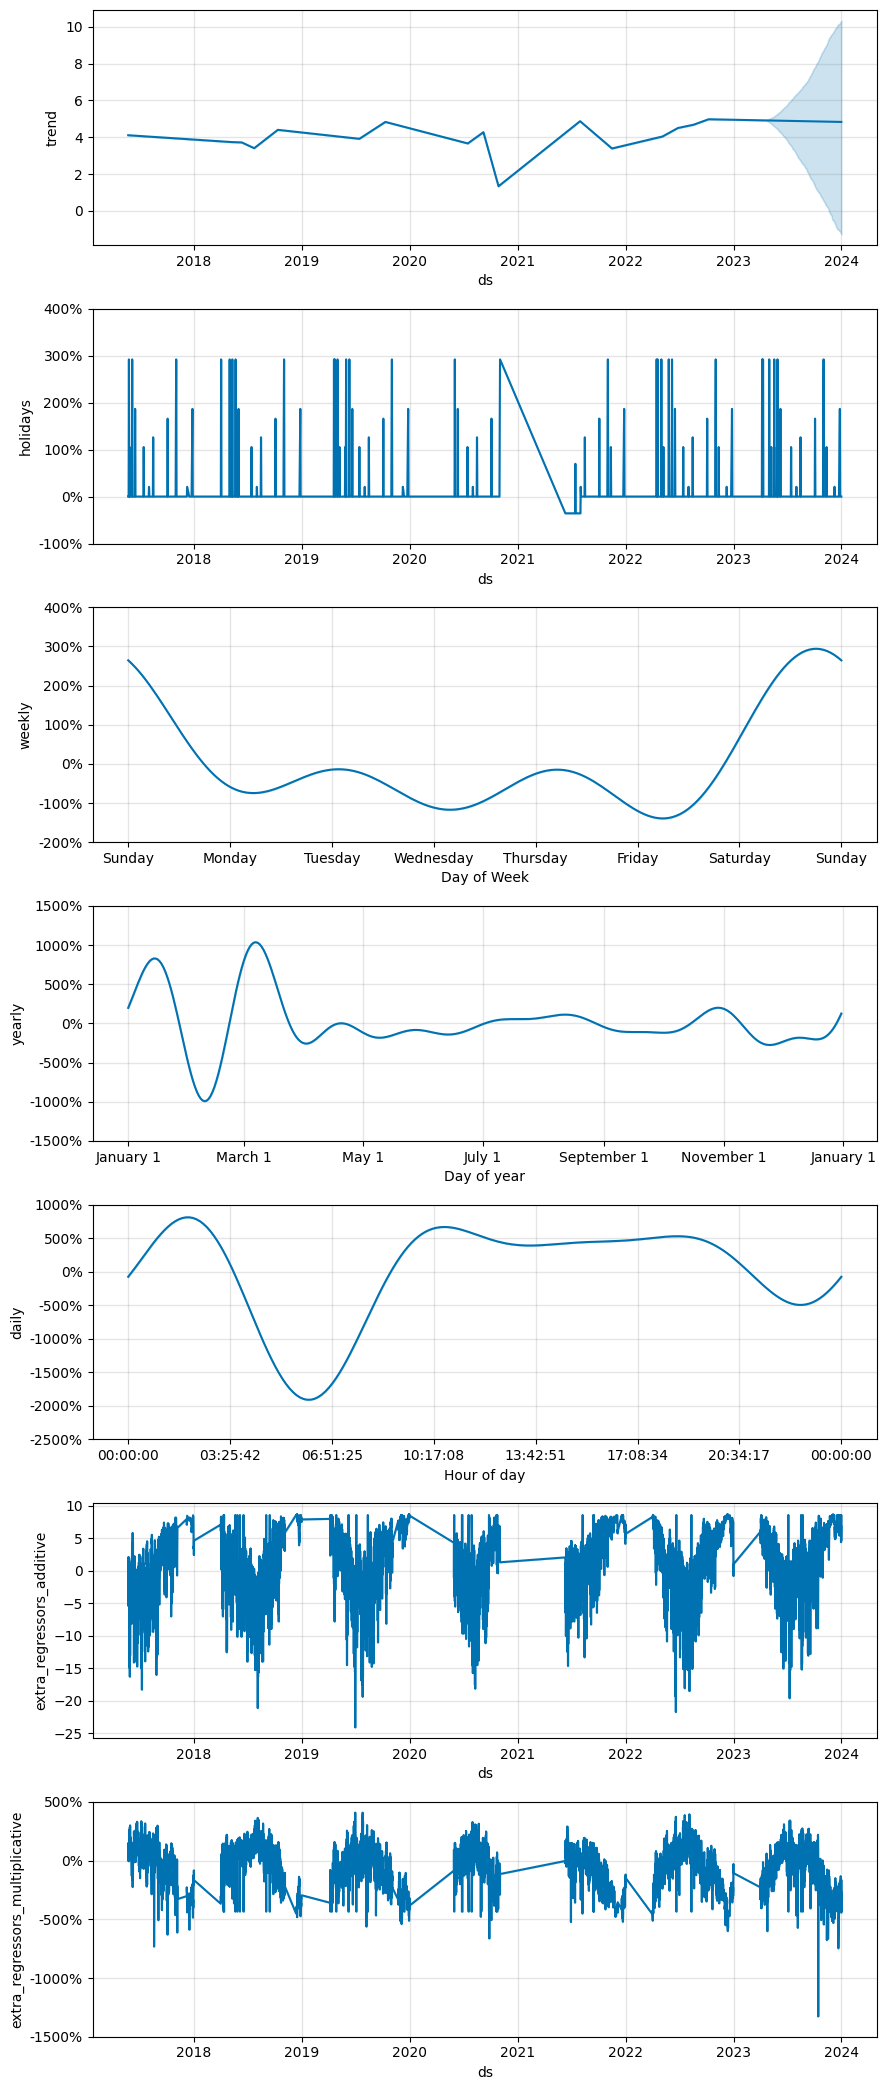

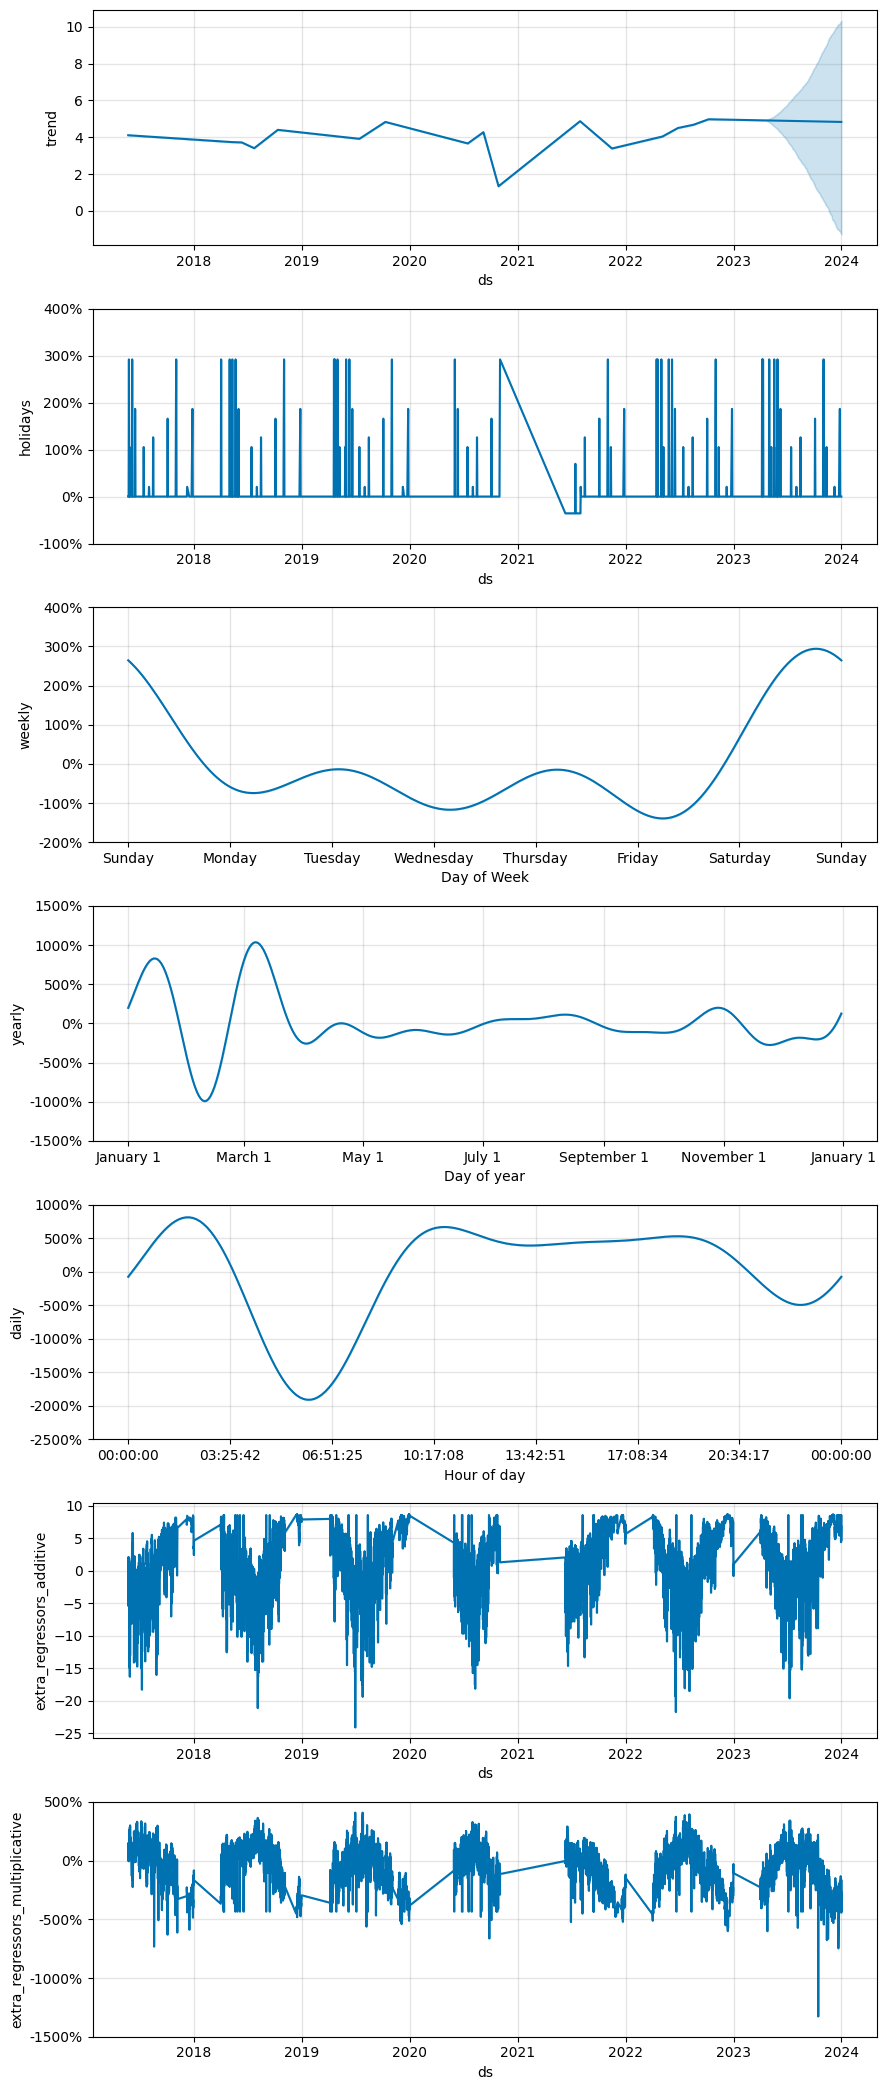

In [17]:
# Create forecast dataframe
future = prophet_df.drop(columns=["y"])[prophet_df["ds"] <= "2024-01-01"]
future = future.reset_index(drop=True).sort_values(by="ds")
forecast = model.predict(future)

# Visualize model components
model.plot_components(forecast)

## Post-processing Forecasts

We apply post-processing to correct any systematic errors in the forecasts,
such as ensuring zero wait times during closures and handling negative predictions.

In [18]:
def post_process_forecast(forecast, closed_data):
    """Apply corrections to forecasted values."""
    # Set predictions to zero during known closures
    closed_mask = forecast['ds'].isin(closed_data.loc[closed_data['closed'] == 1, 'ds'])
    forecast.loc[closed_mask, 'yhat'] = 0
    forecast.loc[closed_mask, 'yhat_lower'] = 0
    forecast.loc[closed_mask, 'yhat_upper'] = 0
    
    # Correct negative predictions
    negative_mask = forecast['yhat'] < 0
    forecast.loc[negative_mask, 'yhat'] = 0
    forecast.loc[negative_mask, 'yhat_lower'] = 0
    forecast.loc[negative_mask, 'yhat_upper'] = 0
    
    return forecast

In [19]:
# Post-process forecast
forecast = post_process_forecast(forecast, future)

## Combining Forecasts with Actual Data for Visualization

For evaluation, we combine our forecasts with the actual observed data.

In [20]:
def combine_forecast_with_actual(forecast, train_data, val_data):
    """Combine forecast with actual data for visualization."""
    forecast.index = pd.to_datetime(forecast.ds)
    
    train_data.index = pd.to_datetime(train_data.ds)
    val_data.index = pd.to_datetime(val_data.ds)
    
    data = pd.concat([train_data, val_data], axis=0)
    forecast.loc[:,'y'] = data.loc[:,'y']
    
    return forecast

In [21]:
# Combine with actual data for visualization
combined_data = combine_forecast_with_actual(forecast, train_df, val_df)

## Visualizing Forecast Performance

We visualize how well our model performs on both training and validation data.

In [31]:
def plot_forecast_comparison(forecast_data, split_year, show_uncertainty=True):
    """Plot forecasts against actual data with training/validation split."""
    fig, ax = plt.subplots(figsize=(14, 8))
    
    # Training period
    train = forecast_data.loc[:str(split_year - 1),:]
    ax.plot(train.index, train.y, 'ko', markersize=3)
    ax.plot(train.index, train.yhat, color=TRAIN_COLOR, lw=0.5)
    if show_uncertainty:
        ax.fill_between(train.index, train.yhat_lower, train.yhat_upper, 
                        color=TRAIN_FILL_COLOR, alpha=TRAIN_FILL_ALPHA)
    
    # Validation period
    val = forecast_data.loc[str(split_year):,:]
    ax.plot(val.index, val.y, 'ro', markersize=3)
    ax.plot(val.index, val.yhat, color=VAL_COLOR, lw=0.5)
    if show_uncertainty:
        ax.fill_between(val.index, val.yhat_lower, val.yhat_upper, 
                        color=VAL_FILL_COLOR, alpha=VAL_FILL_ALPHA)
        
    # Add year divider
    ax.axvline(pd.Timestamp(f'{split_year}-01-01'), color='0.8', alpha=0.7)
    ax.grid(ls=':', lw=0.5)
    
    # Add legend
    from matplotlib.lines import Line2D
    legend_elements = [
        Line2D([0], [0], marker='o', color='w', markerfacecolor='k', markersize=6, label='Training Actual'),
        Line2D([0], [0], color=TRAIN_COLOR, lw=2, label='Training Forecast'),
        Line2D([0], [0], marker='o', color='w', markerfacecolor='r', markersize=6, label='Validation Actual'),
        Line2D([0], [0], color=VAL_COLOR, lw=2, label='Validation Forecast')
    ]
    ax.legend(handles=legend_elements, loc='upper left')
    
    ax.set_title(f'Wait Time Forecast: Training vs Validation (Split at {split_year})', fontsize=14)
    ax.set_ylabel('Wait Time (minutes)', fontsize=12)
    ax.set_xlabel('Date', fontsize=12)
    
    return fig

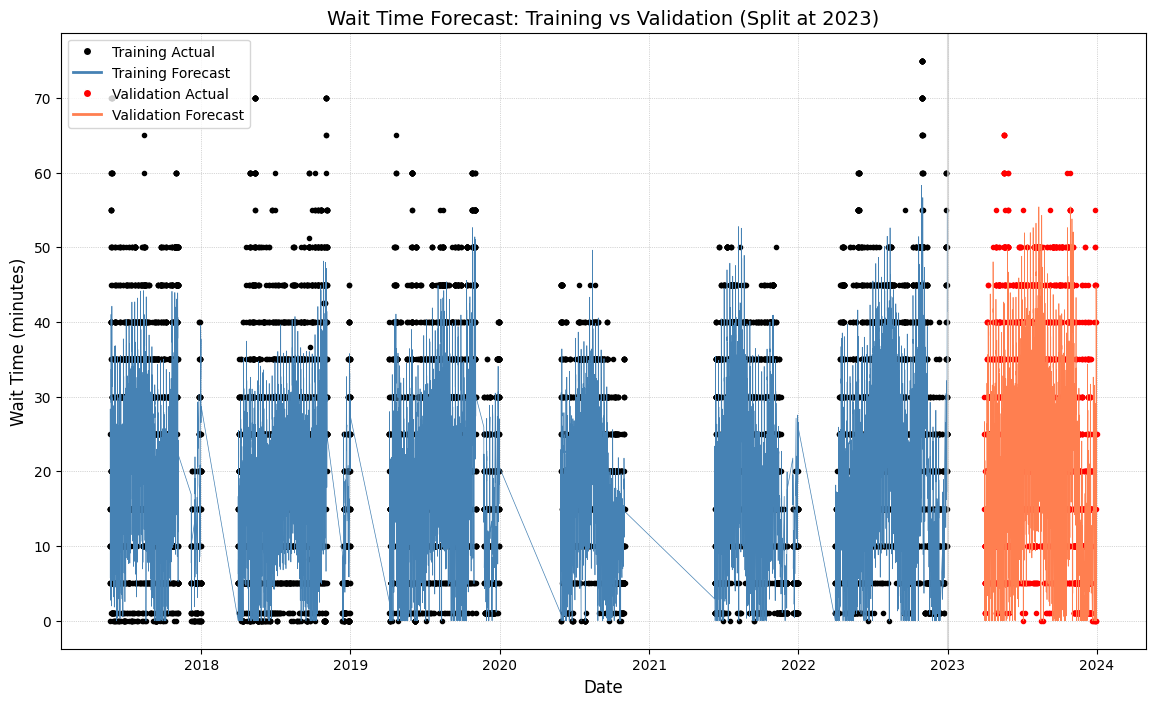

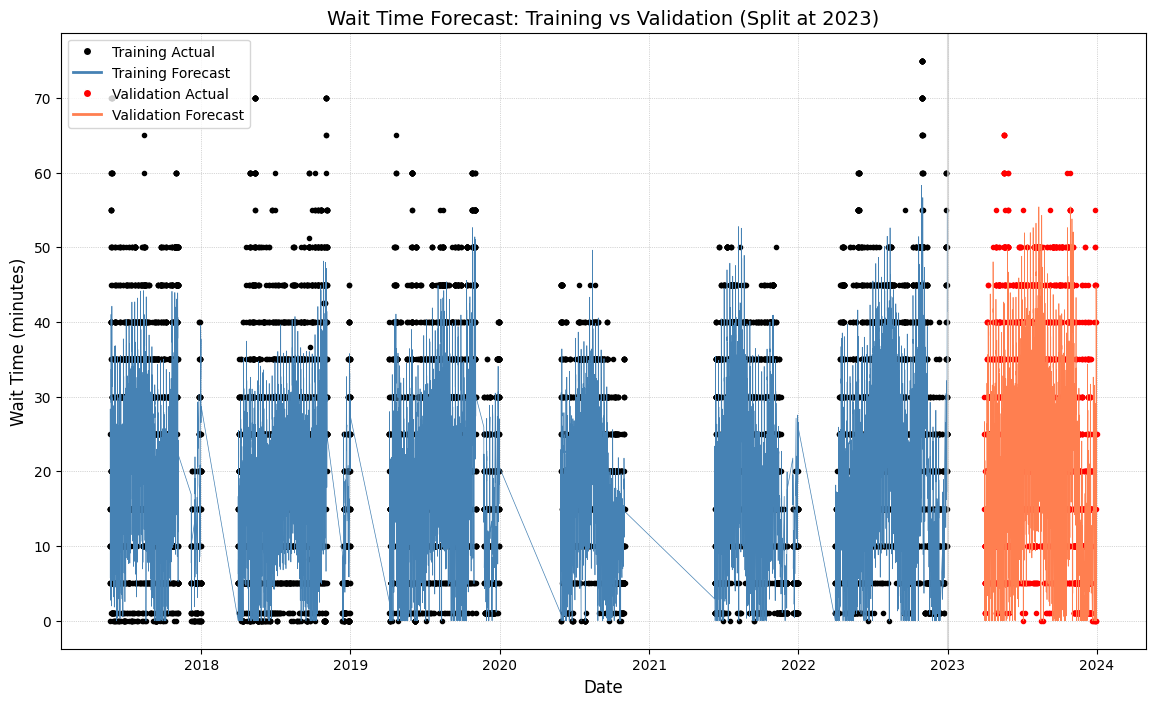

In [33]:
# Plot full timeline
plot_forecast_comparison(combined_data, split_year=2023, show_uncertainty=False)

## Detailed Period Analysis

We examine specific time periods in detail to better understand model performance.

In [37]:
def plot_time_period(forecast_data, start_date, end_date, ax=None, show_uncertainty=True):
    """Plot forecast vs actual for a specific time period."""
    df = forecast_data.loc[start_date:end_date,:]

    df.loc[:,'yhat'].plot(lw=2, ax=ax, color=VAL_COLOR, ls='-', label='forecasts')

    if show_uncertainty:
        ax.fill_between(df.index, df.loc[:,'yhat_lower'], df.loc[:,'yhat_upper'], 
                        color=VAL_FILL_COLOR, alpha=VAL_FILL_ALPHA)
    df.loc[:,'y'].plot(lw=2, ax=ax, color=TRAIN_COLOR, ls='-', label='observations')

    ax.grid(ls=':')
    ax.legend(fontsize=15)
    [l.set_fontsize(13) for l in ax.xaxis.get_ticklabels()]
    [l.set_fontsize(13) for l in ax.yaxis.get_ticklabels()]
    ax.set_ylabel('wait time (minutes)', fontsize=15)
    ax.set_xlabel('', fontsize=15)

    start_date_weekday = pd.Timestamp(start_date).day_name()
    end_date_weekday = pd.Timestamp(end_date).day_name()
    ax.set_title(f'{start_date} ({start_date_weekday}) to {end_date} ({end_date_weekday})', fontsize=18)

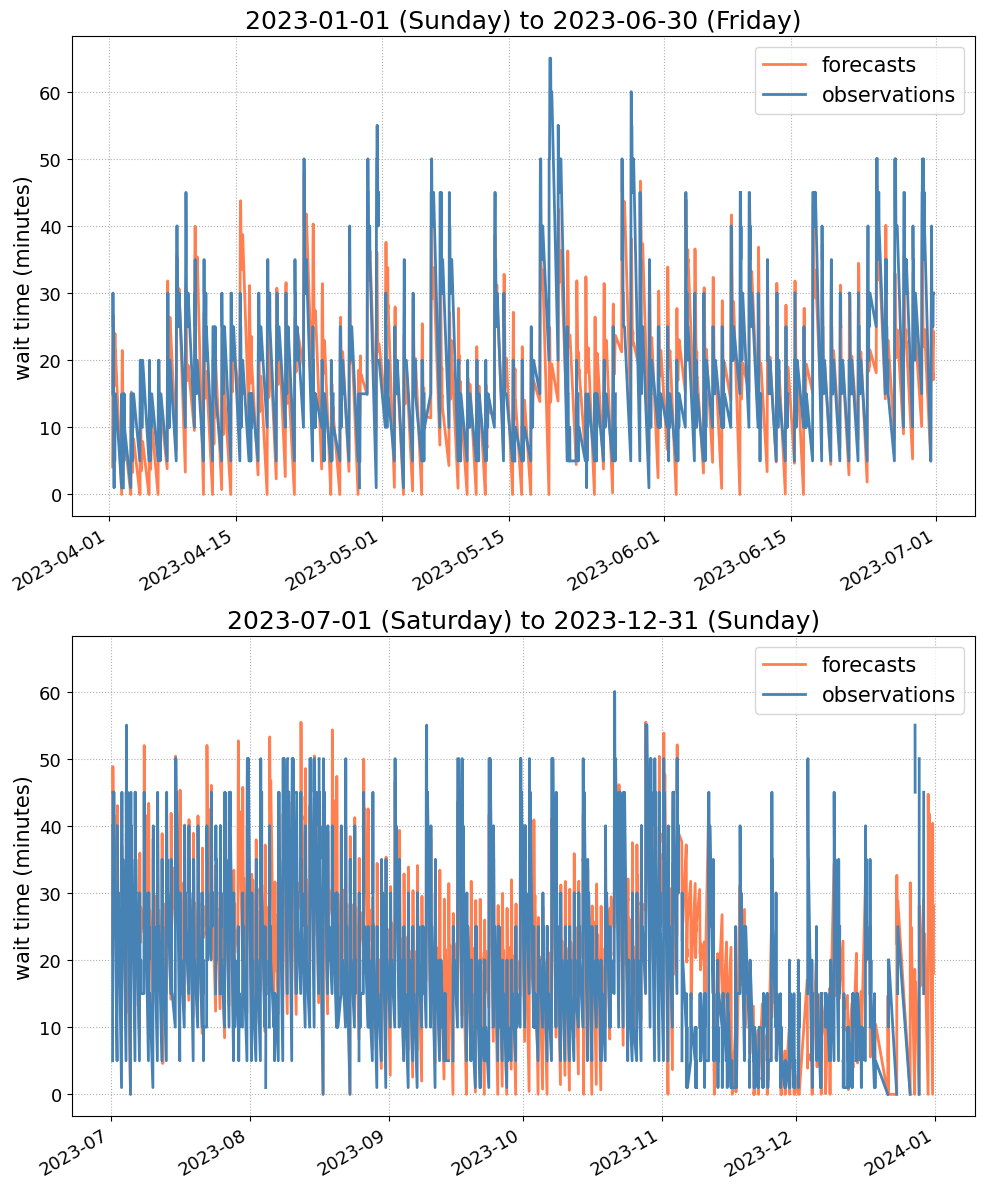

In [38]:
# Plot validation periods in detail
fig, axes = plt.subplots(nrows=2, figsize=(10, 12), sharey=True)
plot_time_period(combined_data, '2023-01-01', '2023-06-30', ax=axes[0], show_uncertainty=False)
plot_time_period(combined_data, '2023-07-01', '2023-12-31', ax=axes[1], show_uncertainty=False)
plt.tight_layout()

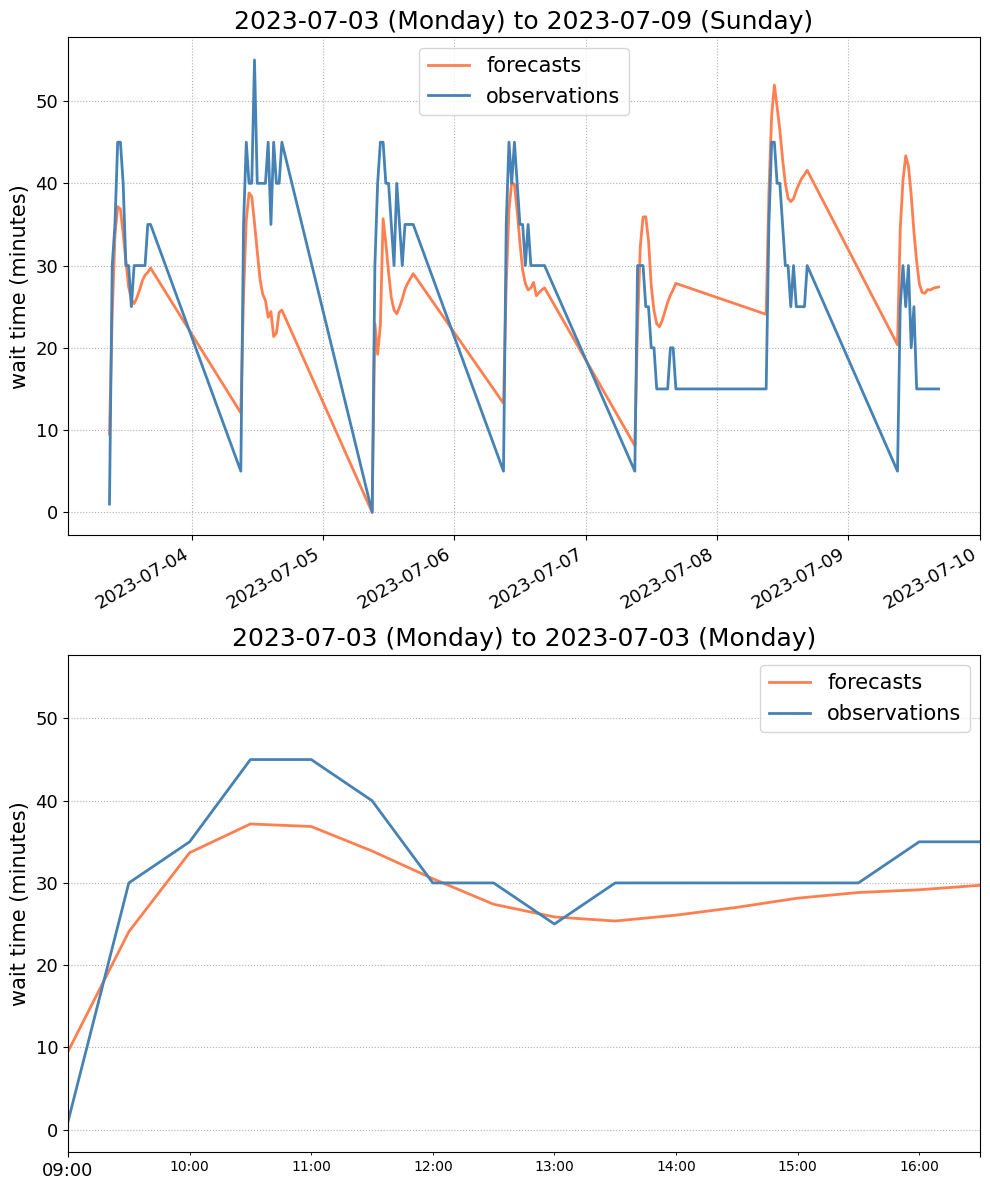

In [39]:
# Plot validation periods in more detail
fig, axes = plt.subplots(nrows=2, figsize=(10, 12), sharey=True)
plot_time_period(combined_data, '2023-07-03', '2023-07-09', ax=axes[0], show_uncertainty=False)
plot_time_period(combined_data, '2023-07-03', '2023-07-03', ax=axes[1], show_uncertainty=False)
plt.tight_layout()

## Model Evaluation Metrics

Finally, we calculate and report standard error metrics to quantify model performance.

In [26]:
def calculate_error_metrics(forecast, val_data):
    """Calculate and display error metrics for model evaluation using standard formulas."""
    # Filter forecast to validation period
    val_forecast = forecast[forecast['ds'].isin(val_data['ds'])].fillna(0)
    
    # Calculate metrics
    mae = mean_absolute_error(val_forecast["y"], val_forecast["yhat"])
    mse = mean_squared_error(val_forecast['y'], val_forecast['yhat'])
    rmse = np.sqrt(mse)
    
    # Standard MAPE calculation - handle zeros with epsilon to avoid division by zero
    epsilon = 1e-8
    abs_pct_errors = np.abs(val_forecast['y'] - val_forecast['yhat']) / (np.abs(val_forecast['y']) + epsilon)
    # Only include points where actual values are non-zero
    non_zero_mask = val_forecast['y'] > 0
    mape = np.mean(abs_pct_errors[non_zero_mask]) * 100
    
    within_ci = ((val_forecast['y'] >= val_forecast['yhat_lower']) & 
                 (val_forecast['y'] <= val_forecast['yhat_upper'])).mean() * 100
    
    print(f"MAE (Mean Absolute Error): {mae:.2f} minutes")
    print(f"RMSE (Root-Mean-Square Deviation): {rmse:.2f} minutes")
    print(f"MAPE (Mean Absolute Percentage Error): {mape:.2f}%")
    print(f"Percentage of predictions within confidence interval: {within_ci:.2f}%")
    
    return {'mae': mae, 'rmse': rmse, 'mape': mape, 'within_ci': within_ci}

In [27]:
# Calculate error metrics
metrics = calculate_error_metrics(forecast, val_df)

MAE (Mean Absolute Error): 8.40 minutes
RMSE (Root-Mean-Square Deviation): 11.12 minutes
MAPE (Mean Absolute Percentage Error): 65.44%
Percentage of predictions within confidence interval: 84.97%
